<font size=7>Latency Animations

animation of spike rast and a sub-sample of latency events

In [1]:
from human_hip.spike_data import  latency_times
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import FancyArrow
import numpy as np
from sklearn import preprocessing
import math
import matplotlib.cm as cm


In [11]:
import matplotlib.pyplot as plt
from braingeneers.analysis.analysis import SpikeData
from scipy.ndimage import gaussian_filter1d
import numpy as np

from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, plot_raster, \
                                 plot_cross_sttc_pairs
import human_hip.spike_data as spike_data
import pickle

# Latency plot

In [3]:
sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-03-e-Hc112823_avv9hckcr1/derived/kilosort2/Hc112823_avv9hckcr1_21841_120323_3_acqm.zip" )


In [4]:
with open( 'curate_latencies_good_pairs.pkl' , 'rb') as my_file:
    good_pairs = pickle.load(my_file)
print(len(good_pairs))

466


(<Axes: xlabel='Time (s)', ylabel='Unit'>,
 <Axes: xlabel='Time (ms)', ylabel='Population Firing Rate (Hz)'>)

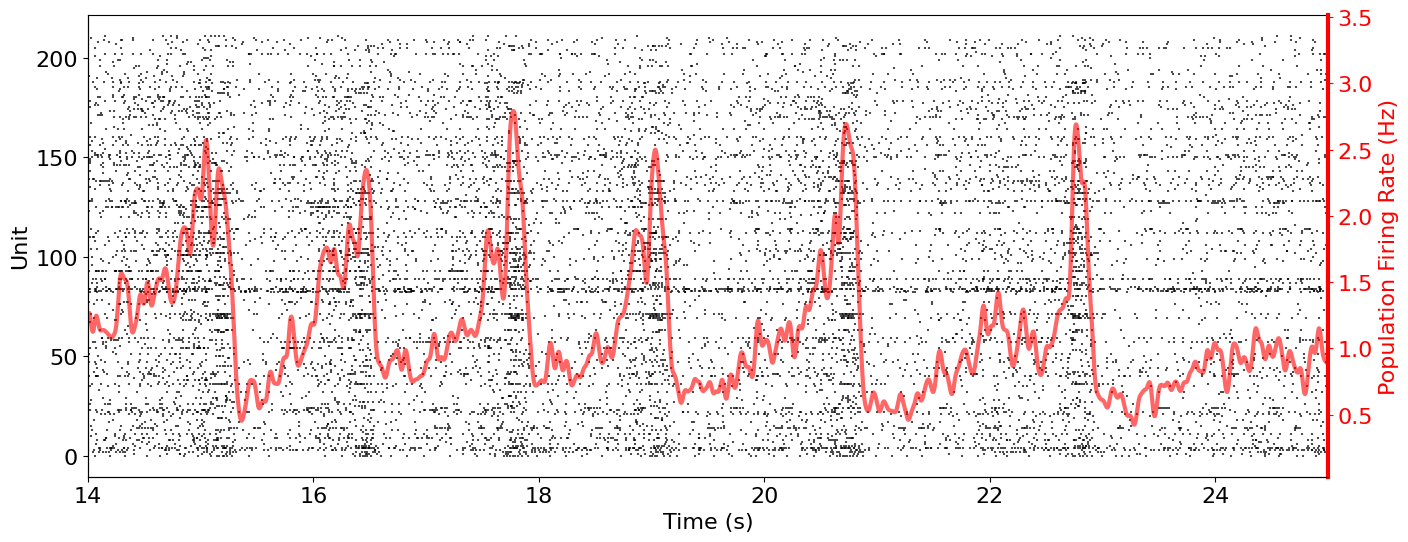

In [12]:
plot_raster( sd, xlim=(14,25) )

In [ ]:

def animate_latencies(sd, pairs, movie_range_ms=None, frame_interval_ms=500, directed=True, directed_backwards=False, filename="latencies.mp4",
                      latency_ms_cutoff_low=1, latency_ms_cutoff_high=15, plot_vector=False, min_dist=0 ):

    # Create plot of neuron positions
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)
    fig = plt.figure(figsize=(8, 8))
    ax = plt.axes()                    # get axis element to later create plot
    ax.scatter( neuron_xy[:,0], neuron_xy[:,1], alpha=0.15, c='grey')

    # Create raster of when latencies occur. "Neurons" are now neuron pairs (n1,n2), where n1->n2
    latency_raster = {}
    for pair in pairs:
        if directed:
            latency_raster[ (pair[0],pair[1]) ] =  latency_times( pair[0], pair[1], sd, ms_cutoff_low=latency_ms_cutoff_low, ms_cutoff_high=latency_ms_cutoff_high, positive_only=True )
            if directed_backwards:
                latency_raster[ (pair[1],pair[0]) ] =  latency_times( pair[1], pair[0], sd, ms_cutoff_low=latency_ms_cutoff_low, ms_cutoff_high=latency_ms_cutoff_high, positive_only=True )
        else:
            latency_raster[ (pair[0],pair[1]) ] = latency_times( pair[0], pair[1], sd, ms_cutoff_low=latency_ms_cutoff_low, ms_cutoff_high=latency_ms_cutoff_high, positive_only=False)
    latency_raster = {k:v for k,v in latency_raster.items() if len(v)>0 } # remove empty lists
    print(f"{sum([ len(x) for x in latency_raster.values() ])} latency events occured in total spikedata")
    min_dist=0 
    for key in list(latency_raster.keys()):
        if math.dist( neuron_xy[key[0]] , neuron_xy[key[1]] ) < min_dist:
            del latency_raster[key]
    #if min_dist>0: print(f"{sum([ len(x) for x in latency_raster.values() ])} latency events occured above {min_dist} um distance")

    # Create list of neurons that fire at each timepoint
    movie_range_ms = range(0, int(sd.length), 1000) if movie_range_ms is None else movie_range_ms
    video_length = round( len(movie_range_ms)*frame_interval_ms/1000/60 ,3)
    print(f"Making animation of {video_length} minutes")
    if video_length > 10:
        raise ValueError(f"Video length is over 10 minutes. Please shorten movie_range_ms or frame_interval_ms")    
    neurons_by_time = []
    for timepoint in movie_range_ms:                                # loop over time, each second
        firing_neurons = []
        for pair,times in latency_raster.items() :                                   # loop over neurons
            if np.sum( np.abs( times - timepoint ) < movie_range_ms.step/2 ):             # if neuron pair fires least once within  1 second timepoint
                firing_neurons.append( pair )
        neurons_by_time.append( firing_neurons )

    # Create animation
    cmap = cm.get_cmap('hsv')
    def animate(timepoint):
        ax.set_title(f"{(movie_range_ms.start+timepoint*movie_range_ms.step)/1000:.3f} seconds")
        [ patch.remove() for patch in ax.patches ]
        for pair in neurons_by_time[timepoint]:
            start = neuron_xy[ pair[0] ]
            end = neuron_xy[pair[1]] - start
            end = preprocessing.normalize(end) * 75 if plot_vector  else end
            angle= (math.atan2(-(end[1]), end[0]) + np.pi) / (2 * np.pi)
            ax.add_patch( FancyArrow(  start[0], start[1], end[0], end[1], length_includes_head=True, head_width=25,linewidth=1,
                                      color= cmap(angle), alpha=0.7 ) )
    anim = FuncAnimation(fig, animate, frames=range(len(neurons_by_time)), interval=frame_interval_ms, blit=False) 
    anim.save( filename )
    print( f"Saved animation to {filename}" )


# Combine plots

In [16]:
import matplotlib.pyplot as plt
from braingeneers.analysis.analysis import SpikeData
from scipy.ndimage import gaussian_filter1d
import numpy as np

/tmp/ipykernel_54868/1720114470.py:15: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


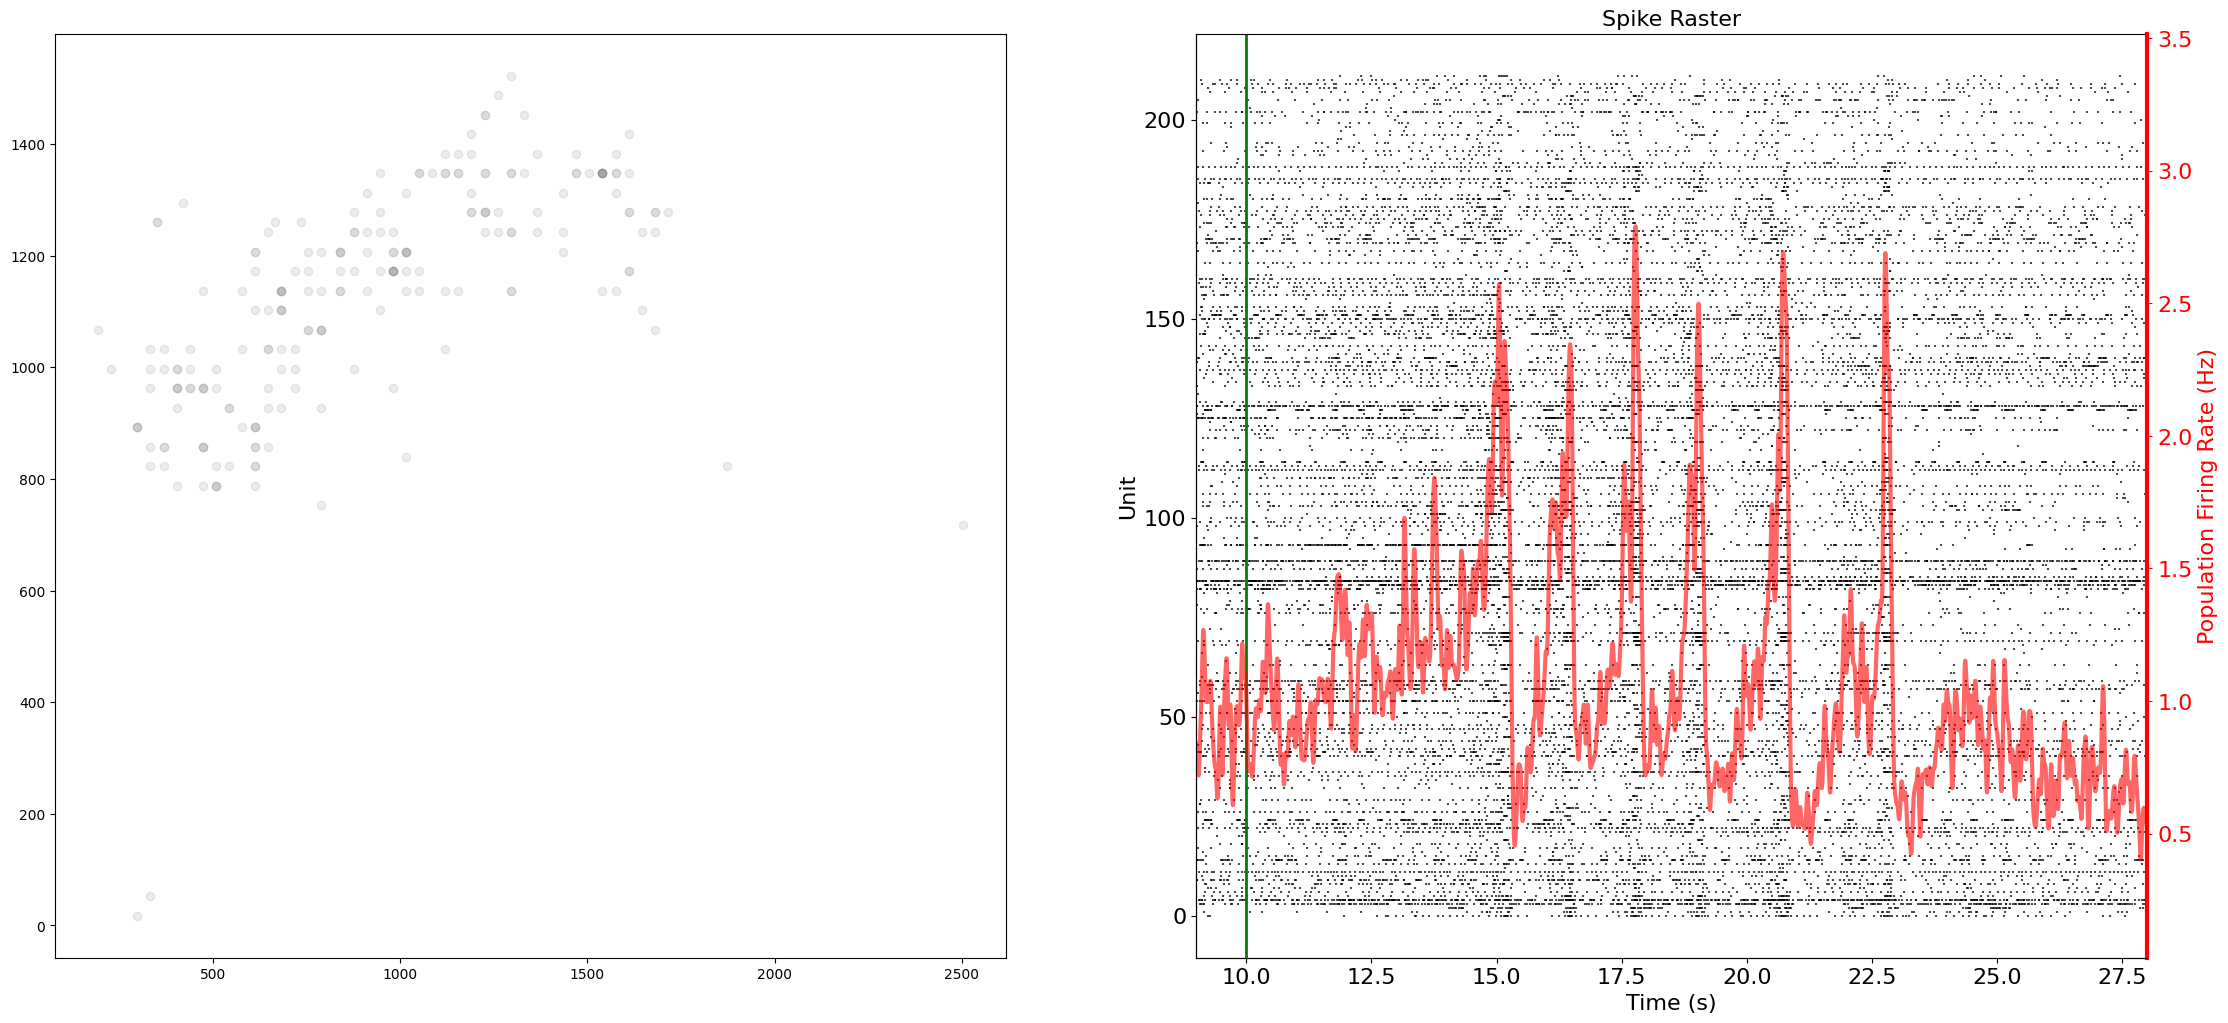

In [25]:
pairs = good_pairs
min_dist=0
movie_range_ms = range(5000,9000,30)
plot_vector=False
latency_ms_cutoff_low=1
latency_ms_cutoff_high=15
directed=True
directed_backwards=True

fig, plots = plt.subplots(nrows=1,ncols=2,figsize=(27,12))

### Code for latency Plot ###
# Create plot of neuron positions
neuron_xy = []
for neuron in sd.neuron_data[0].values():
    neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
neuron_xy = np.array(neuron_xy)
plot0 = plots[0].scatter( neuron_xy[:,0], neuron_xy[:,1], alpha=0.15, c='grey')

# Create raster of when latencies occur. "Neurons" are now neuron pairs (n1,n2), where n1->n2
latency_raster = {}
for pair in pairs:
    if directed:
        latency_raster[ (pair[0],pair[1]) ] =  latency_times( pair[0], pair[1], sd, ms_cutoff_low=latency_ms_cutoff_low, ms_cutoff_high=latency_ms_cutoff_high, positive_only=True )
        if directed_backwards:
            latency_raster[ (pair[1],pair[0]) ] =  latency_times( pair[1], pair[0], sd, ms_cutoff_low=latency_ms_cutoff_low, ms_cutoff_high=latency_ms_cutoff_high, positive_only=True )
    else:
        latency_raster[ (pair[0],pair[1]) ] = latency_times( pair[0], pair[1], sd, ms_cutoff_low=latency_ms_cutoff_low, ms_cutoff_high=latency_ms_cutoff_high, positive_only=False)
latency_raster = {k:v for k,v in latency_raster.items() if len(v)>0 } # remove empty lists

for key in list(latency_raster.keys()):
    if math.dist( neuron_xy[key[0]] , neuron_xy[key[1]] ) < min_dist:
        del latency_raster[key]

# Create list of neurons that fire at each timepoint
neurons_by_time = []
for timepoint in movie_range_ms:                                # loop over time, each 5ms
    firing_neurons = []
    for pair,times in latency_raster.items() :                                   # loop over neurons
        if np.sum( np.abs( times - timepoint ) < movie_range_ms.step/2 ):             # if neuron pair fires least once 
            firing_neurons.append( pair )
    neurons_by_time.append( firing_neurons )



### Code for Raster ###
# Get firing rate
pop_rate = sd.binned(bin_size=1)
pop_fr = gaussian_filter1d(pop_rate.astype(float), sigma=20)
bins = np.linspace(0, sd.length, pop_rate.shape[0] ) #/1000
plots[1].set_title("Spike Raster", fontsize=16)

y = 0
for vv in sd.train:
    plots[1].scatter(vv/1000, [y]*len(vv), marker="|", c='k', s=4, alpha=0.7)
    y += 1
plots[1].set_xlabel("Time (s)", fontsize=16)
plots[1].set_ylabel("Unit", fontsize=16)
plots[1].xaxis.set_tick_params(labelsize=16)
plots[1].yaxis.set_tick_params(labelsize=16)

axs1 = plots[1].twinx()
axs1.yaxis.set_label_position("right") 
axs1.spines['right'].set_color('r')
axs1.spines['right'].set_linewidth(3)
axs1.plot(bins/1000, pop_fr, color='r', linewidth=3, alpha=0.6)
axs1.set_ylabel("Population Firing Rate (Hz)", fontsize=16, color='r')
axs1.set_xlabel("Time (ms)", fontsize=16)
axs1.yaxis.set_tick_params(labelsize=16)
axs1.set_xlim((9, 28))
#axs1.set_ylim(ylim)
axs1.spines['top'].set_visible(False)
axs1.get_xaxis().set_visible(False)
axs1.tick_params(left=False, right=True, labelleft=False, labelright=True,
                bottom=False, labelbottom=True)
axs1.tick_params(axis='y', colors='r')
vl = plots[1].axvline(x=10, color='green', linewidth=2, linestyle='-')
 


In [27]:

# animation function.  This is called sequentially
cmap = cm.get_cmap('hsv')
movie_range_list= list(movie_range_ms)
def animate(i):
    # Latency plot
    plots[0].set_title(f"{(movie_range_ms.start+timepoint*movie_range_ms.step)/1000:.3f} seconds")
    [ patch.remove() for patch in plots[0].patches ]
    for pair in neurons_by_time[i]:
        start = neuron_xy[ pair[0] ]
        end = neuron_xy[pair[1]] - start
        end = preprocessing.normalize(end) * 75 if plot_vector  else end
        angle= (math.atan2(-(end[1]), end[0]) + np.pi) / (2 * np.pi)
        plots[0].add_patch( FancyArrow(  start[0], start[1], end[0], end[1], length_includes_head=True, head_width=25,linewidth=1,
                                    color= cmap(angle), alpha=0.7 ) )
    # Raster Plot
    t = 9 + movie_range_list[i]/1000
    vl.set_xdata([t,t])
    return plots

anim = FuncAnimation(fig, animate, frames=range(len(neurons_by_time)), interval=500, blit=False)  
anim.save( 'media/try_1.mp4' )

/tmp/ipykernel_54868/3344886238.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')
